In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem import rdMolDescriptors
import numpy as np
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem
import mols2grid
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

In [2]:
def get_ligand(df):
    '''
    From a ligand's SMILES, generate their RDKit molecule. Note that
    some ligands are NOT SMILES strings but short hand notation
    and must be manually converted to SMILES. Others are the SMILES
    strings with their metal center, which has to be also manually
    stripped out.
    '''
    ligands_1 = df['catalyst_1_ID_1_SMILES'].unique().tolist()
    ligands_2 = df['catalyst_2_ID_1_SMILES'].unique().tolist()
    ligands = np.unique(ligands_1 + ligands_2)
    
    ligand_mols = []
    ligand_smiles = []
    
    for i in ligands:
        if pd.isna(i) == True or i == 'nan':
            pass
        else:
            if i == '(DTBNpP)Pd(allyl)Cl':
                i = 'CC(C)(C)CP(C(C)(C)C)C(C)(C)C'
            elif i == '(IPr)Pd(Allyl)Cl':
                i = 'CC(C)c1cccc(C(C)C)c1N2[C]N(C=C2)c3c(cccc3C(C)C)C(C)C'
            elif i == '(QPhos)Pd(crotyl)Cl':
                i = '[Fe].CC(C)(C)P([C]1[CH][CH][CH][CH]1)C(C)(C)C.c2ccc(cc2)[C]3[C]([C]([C]([C]3c4ccccc4)c5ccccc5)c6ccccc6)c7ccccc7'
            elif i == 'P(C1CCCCC1)(C1CCCCC1)/C(=C(/c1ccccc1)c1ccccc1)C':
                i = 'C/C(P(C1CCCCC1)C2CCCCC2)=C(c3ccccc3)\c4ccccc4'
            elif i == '2G XPhos':
                i = 'CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=C(P(C3CCCCC3)C4CCCCC4)C=CC=C2'
            elif i == '3G OMs RockPhos':
                i = 'CC1=C(C2=C(C(C)C)C=C(C(C)C)C=C2C(C)C)C(P(C(C)(C)C)C(C)(C)C)=C(OC)C=C1'
            elif i == '3G OMs RuPhos' or i == 'RuPhos' or i == 'RuPhos Palladacycle' or i == 'RuPhos Pd G4' or i == 'WS RuPhos':
                i = 'CC(C)Oc1cccc(c1c2ccccc2P(C3CCCCC3)C4CCCCC4)OC(C)C'
            elif i == '3G OMs XanthPhos' or i == 'Xantphos Pd G4':
                i = 'O6c1c(cccc1P(c2ccccc2)c3ccccc3)C(c7cccc(P(c4ccccc4)c5ccccc5)c67)(C)C'
            elif i == '3G OMs tBuBrettPhos':
                i = 'COc1ccc(OC)c(c1P(C(C)(C)C)C(C)(C)C)-c2c(cc(cc2C(C)C)C(C)C)C(C)C'
            elif i == 'BrettPhos Palladacycle':
                i = 'COc1ccc(OC)c(c1P(C(C)(C)C)C(C)(C)C)c2c(cc(cc2C(C)C)C(C)C)C(C)C'
            elif i == 'Pd-PEPPS-IPent':
                i = 'CCC(c1c(N2C=CN(C2)c3c(C(CC)CC)cccc3CCC)c(C(CC)CC)ccc1)CC'
            elif i == 'C(COC)OC.[Ni](Cl)Cl':
                i = 'C(COC)OC'
            elif i == 'C(O[Pd]OC(C)=O)(C)=O':
                i = 'OC(C)=O'
            elif i == 'C1(C)(C)c2c(c(P(c3ccccc3)c3ccccc3)ccc2)Oc2c1cccc2P(c1ccccc1)c1ccccc1.c1ccc(c(c1)[Pd+])c1ccccc1NC.[O-]S(C)(=O)=O':
                i = 'CC1(c2cccc(P(c3ccccc3)c4ccccc4)c2Oc5c(P(c6ccccc6)c7ccccc7)cccc51)C'
            elif i == 'Cl[Ni]Cl.C1(P(C2CCCCC2)C2CCCCC2)CCCCC1.C1(P(C2CCCCC2)C2CCCCC2)CCCCC1':
                i = 'C1(P(C2CCCCC2)C2CCCCC2)CCCCC1'
            elif i == 'P(C1CCCC1)(C(C)(C)C)C(C)(C)C.P(C1CCCC1)(C(C)(C)C)C(C)(C)C.[Pd](Cl)Cl.[Fe]':
                i = 'P(C1CCCC1)(C(C)(C)C)C(C)(C)C.P(C1CCCC1)(C(C)(C)C)C(C)(C)C.[Fe]'
            elif i == 'SPhos Palladacycle' or i == 'WS Sphos':
                i = 'COc1cccc(OC)c1-c2ccccc2P(C3CCCCC3)C4CCCCC4'
            elif i == '[Ni](Br)Br.P(c1ccccc1)(c1ccccc1)c1ccccc1.P(c1ccccc1)(c1ccccc1)c1ccccc1':
                i = 'P(c1ccccc1)(c1ccccc1)c1ccccc1'
            elif i == '[Pd].C(P(C(C)(C)C)C(C)(C)C)(C)(C)C.C(P(C(C)(C)C)C(C)(C)C)(C)(C)C':
                i = 'C(P(C(C)(C)C)C(C)(C)C)(C)(C)C'
            elif i == 'c1(c(c(ccc1OC)OC)P(C1CCCCC1)C1CCCCC1)c1c(cc(cc1C(C)C)C(C)C)C(C)C.c1(ccccc1c1ccccc1N)[Pd+].[O-]S(C)(=O)=O':
                i = 'COc1c(c2c(C(C)C)cc(C(C)C)cc2C(C)C)c(P(C3CCCCC3)C4CCCCC4)c(OC)cc1'
            elif i == 'c12c([Pd-](N(CC1)C)[P+](c1c(c3c(cc(cc3C(C)C)C(C)C)C(C)C)cccc1)(C1CCCCC1)C1CCCCC1)cccc2':
                i = 'CC(C)c1c(c2ccccc2)c(C(C)C)cc(C(C)C)c1'
            elif i == 'c1c(c(ccc1)[Pd+])c1ccccc1N.[O-]S(C)(=O)=O.c1c(c(c(cc1C(C)C)C(C)C)c1c(ccc(c1P(C(C)(C)C)C(C)(C)C)OC)OC)C(C)C':
                i = 'CC(C)c1cc(C(C)C)c(c2c(P(C(C)(C)C)C(C)(C)C)c(OC)ccc2OC)c(C(C)C)c1'
            elif i == 'c1c(cc(c(c1C(C)C)c1c(P(C2CCCCC2)C2CCCCC2)cccc1)C(C)C)C(C)C.c1cc(c(cc1)CCN)[Pd]Cl.CC(OC)(C)C':
                i = 'CC(C)c1cc(C(C)C)cc(C(C)C)c1c2ccccc2P(C3CCCCC3)C4CCCCC4'
            elif i == 'c1ccc(c(c1)c1c(cccc1)N)[Pd]Cl.c1(ccccc1c1c(cccc1OC(C)C)OC(C)C)P(C1CCCCC1)C1CCCCC1':
                i = 'CC(C)Oc1c(c2c(P(C3CCCCC3)C4CCCCC4)cccc2)c(OC(C)C)ccc1'
            elif i == 'c1ccc2c(c1)c(ccc2)[Ni](P(c1ccccc1)(c1ccccc1)c1ccccc1)(P(c1ccccc1)(c1ccccc1)c1ccccc1)Cl':
                i == 'P(c1ccccc1)(c2ccccc2)c3ccccc3'
            elif i == 'c1cccc(c1CCN)[Pd]Cl.C(C)(C)(P(C(C)(C)C)c1ccccc1c1c(cc(cc1C(C)C)C(C)C)C(C)C)C':
                i = 'CC(P(c1c(c2c(C(C)C)cc(C(C)C)cc2C(C)C)cccc1)C(C)(C)C)(C)C'

            ligand_mols.append(Chem.MolFromSmiles(i))
            ligand_smiles.append(i)

    return ligand_smiles, ligand_mols

def canon_smiles(smiles):
    '''
    Generating the canonical SMILES.
    '''
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
    return smiles

def find_label(df, smiles_list, label):
    '''
    Labeling a set of SMILES strings in the dataframe for easy
    PCA color coding.
    '''
    smiles_list = [canon_smiles(x) for x in smiles_list]
    for x in smiles_list:
        df.loc[df['ligand_canon_smiles'] == x, ['label']] = label
    return df

def one_hot_array_to_df(one_hot_array, one_hot_col_names):
    '''
    Turning the fingerprints array into a dataframe for
    concatenation into the PCA dataframe for easier access
    to information.
    '''
    one_hot_col_df = pd.DataFrame()
    
    for i in range(one_hot_array.shape[1]):
        col_name = one_hot_col_names[i]
        col = one_hot_array[:,i]
        one_hot_col_df[col_name] = col
    return one_hot_col_df

In [3]:
# Example with buchwald dataset.
buchwald = pd.read_csv('data/cleaned_datasets/buchwald.csv', index_col=0)

In [4]:
smiles, mols = get_ligand(buchwald)
# Somehow, SK-CC02-A disappeared, but it's definitely in there so manually adding it back in.
smiles.append('CCCCP([C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2)[C@@]45C[C@@H]6C[C@@H](C[C@@H](C6)C4)C5')
mols.append(Chem.MolFromSmiles('CCCCP([C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2)[C@@]45C[C@@H]6C[C@@H](C[C@@H](C6)C4)C5'))
s = [canon_smiles(x) for x in smiles]

In [5]:
buchwald_pca_df = pd.DataFrame()
buchwald_pca_df['ligand_canon_smiles'] = s
buchwald_pca_df['mol'] = mols

fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in buchwald_pca_df['mol']]
buchwald_pca_df['fps'] = fps
buchwald_pca_df['label'] = 'ligand'

In [6]:
# best in class ligands: RuPhos, BrettPhos, tBuXPhos, tBuBrettPhos, 
best = ['CC(C)Oc1cccc(c1c2ccccc2P(C3CCCCC3)C4CCCCC4)OC(C)C', 'COc1ccc(OC)c(c1P(C(C)(C)C)C(C)(C)C)c2c(cc(cc2C(C)C)C(C)C)C(C)C',
       'CC(C1=CC(C(C)C)=C(C2=CC=CC=C2P(C(C)(C)C)C(C)(C)C)C(C(C)C)=C1)C', 'COc1ccc(OC)c(c1P(C(C)(C)C)C(C)(C)C)-c2c(cc(cc2C(C)C)C(C)C)C(C)C']
best = [canon_smiles(x) for x in best]
# worst in class ligands: PtBu3, cataCXium A, SK-CC02-A, Me4tBuXPhos, AcOH, PPh3
worst = ['CC(C)(C)P(C(C)(C)C)C(C)(C)C', 'CCCCP([C@]12C[C@H]3C[C@H](C[C@H](C3)C1)C2)[C@@]45C[C@@H]6C[C@@H](C[C@@H](C6)C4)C5',
        'C1(C(CCC1)[Pd]Cl)CN(C)C.P(C1[C@H]2C[C@@H](C1)CC2)C1[C@@H]2C[C@H](C1)CC2.C1CCCC1.[Fe]',
        'CC(C)c1cc(C(C)C)c(c(c1)C(C)C)-c2c(C)c(C)c(C)c(C)c2P(C(C)(C)C)C(C)(C)C', 'OC(C)=O',
        'P(c1ccccc1)(c2ccccc2)c3ccccc3']
worst = [canon_smiles(x) for x in worst]
# ligand in best AND worst in class depending on other factors (i.e. Generation etc.): Xantphos
both = ['O6c1c(cccc1P(c2ccccc2)c3ccccc3)C(c7cccc(P(c4ccccc4)c5ccccc5)c67)(C)C']
both = [canon_smiles(x) for x in both]

In [7]:
buchwald_pca_df = find_label(buchwald_pca_df, best, 'best in class ligand')
buchwald_pca_df = find_label(buchwald_pca_df, worst, 'worst in class ligand')
buchwald_pca_df = find_label(buchwald_pca_df, both, 'both best AND worst in class ligand')

In [8]:
pca = PCA(n_components=2)
inputs = StandardScaler().fit_transform(buchwald_pca_df['fps'].tolist())

principal_components = pca.fit_transform(inputs)

In [9]:
buchwald_pca_df['pc_1'] = principal_components[:,0]
buchwald_pca_df['pc_2'] = principal_components[:,1]

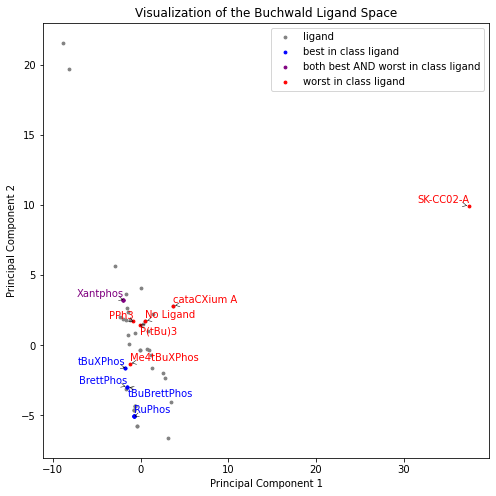

In [10]:
### Plotting ###
colors = ['gray', 'blue', 'purple', 'red']
figure(figsize=(8,8))
for target,color in zip(buchwald_pca_df['label'].unique(), colors):
    idxs = buchwald_pca_df.loc[buchwald_pca_df['label'] == target].index
    plt.scatter(buchwald_pca_df.loc[idxs, 'pc_1'], buchwald_pca_df.loc[idxs, 'pc_2'], c=color, s=8)

plt.title('Visualization of the Buchwald Ligand Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(buchwald_pca_df['label'].unique())
texts = []
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == best[0], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == best[0], ['pc_2']])[0], 'RuPhos', c='blue'))
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == best[1], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == best[1], ['pc_2']])[0], 'BrettPhos', c='blue'))
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == best[2], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == best[2], ['pc_2']])[0], 'tBuXPhos', c='blue'))
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == best[3], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == best[3], ['pc_2']])[0], 'tBuBrettPhos', c='blue'))

texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[0], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[0], ['pc_2']])[0], 'P(tBu)3', c='red'))
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[1], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[1], ['pc_2']])[0], 'cataCXium A', c='red'))
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[2], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[2], ['pc_2']])[0], 'SK-CC02-A', c='red'))
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[3], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[3], ['pc_2']])[0], 'Me4tBuXPhos', c='red'))
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[4], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[4], ['pc_2']])[0], 'No Ligand', c='red'))
texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[5], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == worst[5], ['pc_2']])[0], 'PPh3', c='red'))

texts.append(plt.text(np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == both[0], ['pc_1']])[0], np.unique(buchwald_pca_df.loc[buchwald_pca_df['ligand_canon_smiles'] == both[0], ['pc_2']])[0], 'Xantphos', c='purple'))

adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
plt.show()